# Day 6: Factor Portfolio Construction

## Learning Objectives
- Build long-short factor portfolios
- Implement factor neutralization
- Optimize factor-based portfolios
- Backtest factor strategies

## Key Concept
A factor portfolio is a dollar-neutral, long-short portfolio that isolates exposure to a specific factor.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("FACTOR PORTFOLIO CONSTRUCTION - DAY 6")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

FACTOR PORTFOLIO CONSTRUCTION - DAY 6
Data: 1834 days, 63 assets


## 1. Define Factor Scores

In [2]:
def calculate_factor_scores(returns, lookback=252):
    """Calculate various factor scores for each stock."""
    scores = {}
    
    # 1. Momentum (12-1 month)
    mom_12m = returns.rolling(lookback).mean()
    mom_1m = returns.rolling(21).mean()
    scores['momentum'] = (mom_12m - mom_1m).iloc[-1]
    
    # 2. Volatility (inverse for low-vol factor)
    scores['low_vol'] = -returns.rolling(60).std().iloc[-1]
    
    # 3. Size (inverse of volatility as proxy)
    scores['size'] = -returns.std()  # Large = low vol proxy
    
    # 4. Mean Reversion (short-term)
    scores['reversal'] = -returns.rolling(5).mean().iloc[-1]
    
    # 5. Quality (Sharpe ratio as proxy)
    sharpe = returns.mean() / returns.std()
    scores['quality'] = sharpe
    
    return pd.DataFrame(scores)

factor_scores = calculate_factor_scores(returns)
factor_scores = factor_scores.drop('SPY', errors='ignore')  # Remove market proxy

print("\n" + "="*60)
print("FACTOR SCORES SUMMARY")
print("="*60)
print(factor_scores.describe().round(4))


FACTOR SCORES SUMMARY
       momentum  low_vol     size  reversal  quality
count   62.0000  62.0000  62.0000   62.0000  62.0000
mean    -0.0012  -0.0142  -0.0231   -0.0003   0.0366
std      0.0026   0.0064   0.0342    0.0062   0.0197
min     -0.0088  -0.0306  -0.2818   -0.0137  -0.0022
25%     -0.0027  -0.0178  -0.0222   -0.0033   0.0240
50%     -0.0010  -0.0136  -0.0184   -0.0001   0.0359
75%      0.0002  -0.0099  -0.0149    0.0027   0.0486
max      0.0043  -0.0024  -0.0045    0.0259   0.0846


In [3]:
# Standardize factor scores (z-scores)
factor_scores_z = (factor_scores - factor_scores.mean()) / factor_scores.std()

print("\nTop 5 stocks by each factor:")
for col in factor_scores_z.columns:
    top5 = factor_scores_z[col].nlargest(5).index.tolist()
    print(f"{col}: {top5}")


Top 5 stocks by each factor:
momentum: ['CRM', 'TSLA', 'AAPL', 'NFLX', 'ABBV']
low_vol: ['EURUSD', 'AUDUSD', 'GBPUSD', 'USDJPY', 'TLT']
size: ['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'GLD']
reversal: ['CRM', 'ORCL', 'BAC', 'JPM', 'MSFT']
quality: ['NVDA', 'GLD', 'AVGO', 'WMT', 'AAPL']


## 2. Build Long-Short Factor Portfolios

In [4]:
def build_long_short_portfolio(scores, returns, n_long=10, n_short=10):
    """Build a dollar-neutral long-short portfolio based on factor scores."""
    # Rank stocks by score
    ranked = scores.sort_values(ascending=False)
    
    # Select long and short positions
    long_stocks = ranked.head(n_long).index.tolist()
    short_stocks = ranked.tail(n_short).index.tolist()
    
    # Filter to available stocks
    long_stocks = [s for s in long_stocks if s in returns.columns]
    short_stocks = [s for s in short_stocks if s in returns.columns]
    
    # Equal weight within each leg
    long_weight = 1.0 / len(long_stocks)
    short_weight = -1.0 / len(short_stocks)
    
    # Calculate portfolio returns
    long_returns = returns[long_stocks].mean(axis=1) * 1.0  # Long leg
    short_returns = returns[short_stocks].mean(axis=1) * (-1.0)  # Short leg (negative)
    
    portfolio_returns = long_returns + short_returns
    
    return portfolio_returns, long_stocks, short_stocks

# Build portfolios for each factor
factor_portfolios = {}

for factor in factor_scores_z.columns:
    port_ret, longs, shorts = build_long_short_portfolio(
        factor_scores_z[factor], returns
    )
    factor_portfolios[factor] = port_ret
    
    print(f"\n{factor.upper()} Portfolio:")
    print(f"  Long:  {longs}")
    print(f"  Short: {shorts}")


MOMENTUM Portfolio:
  Long:  ['CRM', 'TSLA', 'AAPL', 'NFLX', 'ABBV', 'META', 'BAC', 'MSFT', 'PEP', 'EURUSD']
  Short: ['BLK', 'MRK', 'XOM', 'HON', 'CAT', 'CVX', 'APD', 'BA', 'FCX', 'SLB']

LOW_VOL Portfolio:
  Long:  ['EURUSD', 'AUDUSD', 'GBPUSD', 'USDJPY', 'TLT', 'IRX', 'TYX', 'DIA', 'TNX', 'PLD']
  Short: ['APD', 'FCX', 'SLB', 'NVDA', 'BA', 'CAT', 'NKE', 'TSLA', 'ORCL', 'AVGO']

SIZE Portfolio:
  Long:  ['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'GLD', 'TLT', 'XLV', 'DIA', 'JNJ', 'KO']
  Short: ['AVGO', 'NFLX', 'SLB', 'BA', 'FCX', 'NVDA', 'TNX', 'TSLA', 'FVX', 'IRX']

REVERSAL Portfolio:
  Long:  ['CRM', 'ORCL', 'BAC', 'JPM', 'MSFT', 'META', 'CMCSA', 'AMZN', 'UNH', 'TSLA']
  Short: ['NEE', 'PLD', 'BA', 'PEP', 'SLB', 'JNJ', 'XOM', 'HON', 'BLK', 'AMT']

QUALITY Portfolio:
  Long:  ['NVDA', 'GLD', 'AVGO', 'WMT', 'AAPL', 'GS', 'TSLA', 'XLK', 'GOOGL', 'QQQ']
  Short: ['DIS', 'BA', 'CMCSA', 'NKE', 'IRX', 'GBPUSD', 'EURUSD', 'PFE', 'AUDUSD', 'TLT']


In [5]:
# Analyze factor portfolio performance
print("\n" + "="*70)
print("FACTOR PORTFOLIO PERFORMANCE")
print("="*70)
print(f"{'Factor':<15} {'Return':<12} {'Volatility':<12} {'Sharpe':<10} {'Max DD':<12}")
print("-"*60)

perf_results = []
for factor, port_ret in factor_portfolios.items():
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Max drawdown
    cum_ret = (1 + port_ret).cumprod()
    rolling_max = cum_ret.expanding().max()
    drawdown = (cum_ret - rolling_max) / rolling_max
    max_dd = drawdown.min()
    
    perf_results.append({
        'Factor': factor,
        'Return': ann_ret,
        'Volatility': ann_vol,
        'Sharpe': sharpe,
        'MaxDD': max_dd
    })
    
    print(f"{factor:<15} {ann_ret:<12.2%} {ann_vol:<12.2%} {sharpe:<10.3f} {max_dd:<12.2%}")

perf_df = pd.DataFrame(perf_results)


FACTOR PORTFOLIO PERFORMANCE
Factor          Return       Volatility   Sharpe     Max DD      
------------------------------------------------------------
momentum        5.25%        19.95%       0.263      -53.49%     
low_vol         -18.17%      52.82%       -0.344     -119.66%    
size            -29.60%      51.21%       -0.578     -98.45%     
reversal        9.64%        17.07%       0.565      -42.78%     
quality         27.50%       50.24%       0.547      -80.58%     


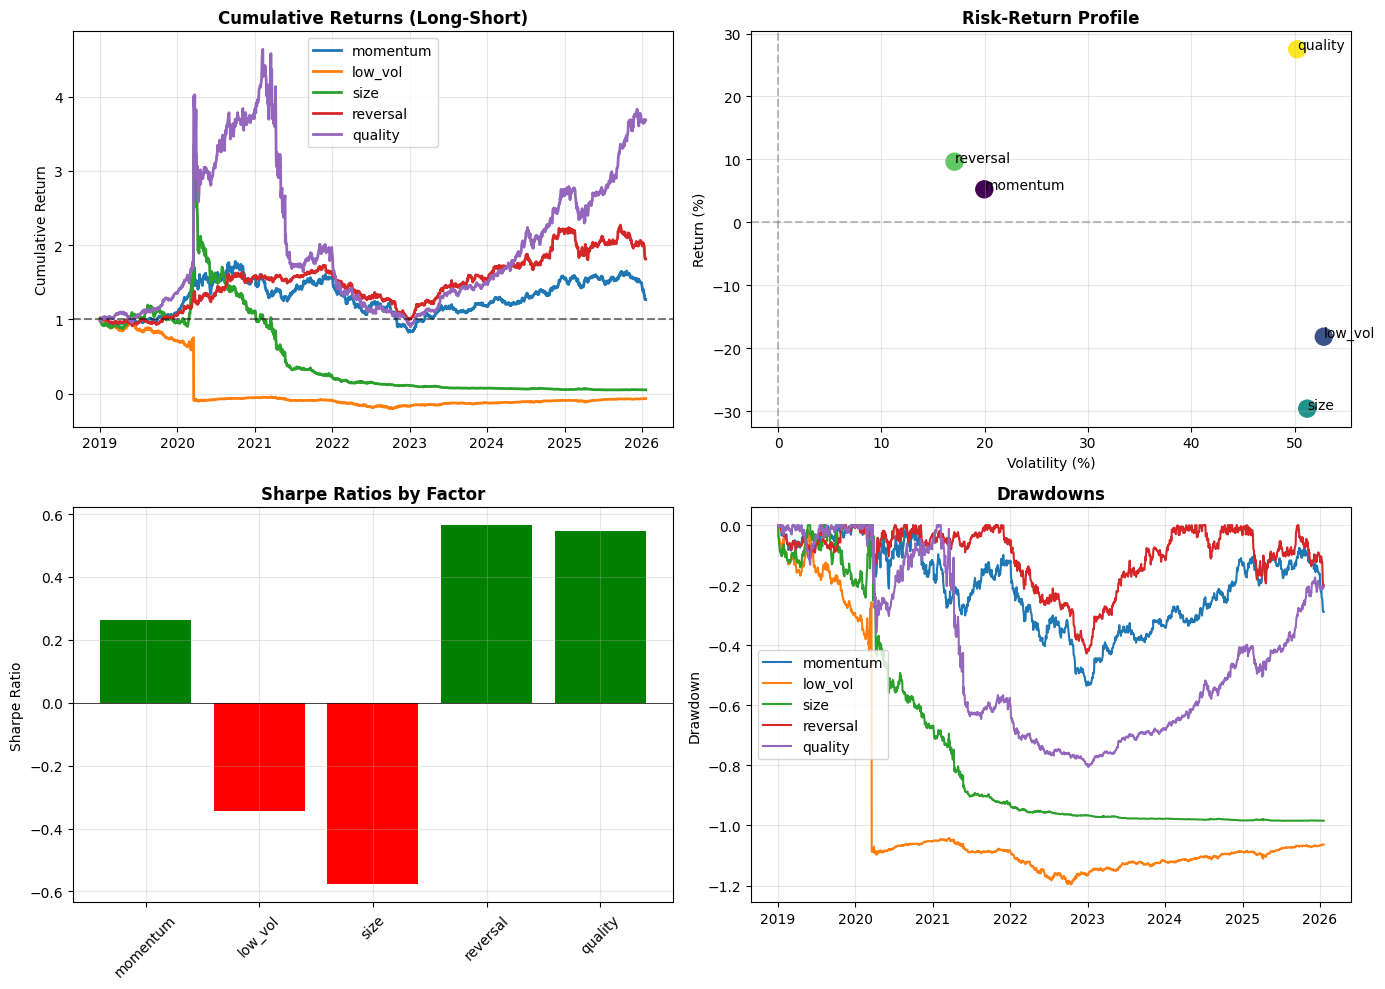

In [6]:
# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    ax1.plot(cum_ret, label=factor, linewidth=2)
ax1.axhline(1, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Cumulative Returns (Long-Short)', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Risk-Return
ax2 = axes[0, 1]
ax2.scatter(perf_df['Volatility']*100, perf_df['Return']*100, s=150, c=range(len(perf_df)), cmap='viridis')
for i, row in perf_df.iterrows():
    ax2.annotate(row['Factor'], (row['Volatility']*100, row['Return']*100), fontsize=10)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Volatility (%)')
ax2.set_ylabel('Return (%)')
ax2.set_title('Risk-Return Profile', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Sharpe ratios
ax3 = axes[1, 0]
colors = ['green' if s > 0 else 'red' for s in perf_df['Sharpe']]
ax3.bar(perf_df['Factor'], perf_df['Sharpe'], color=colors)
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratios by Factor', fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Drawdowns
ax4 = axes[1, 1]
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    rolling_max = cum_ret.expanding().max()
    drawdown = (cum_ret - rolling_max) / rolling_max
    ax4.plot(drawdown, label=factor)
ax4.set_title('Drawdowns', fontweight='bold')
ax4.set_ylabel('Drawdown')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Multi-Factor Portfolio

In [7]:
# Combine factors into a composite score
def create_composite_score(factor_scores_z, weights=None):
    """Create composite factor score with optional custom weights."""
    if weights is None:
        weights = {col: 1.0/len(factor_scores_z.columns) for col in factor_scores_z.columns}
    
    composite = pd.Series(0, index=factor_scores_z.index)
    for factor, weight in weights.items():
        composite += factor_scores_z[factor] * weight
    
    return composite

# Equal-weighted composite
composite_score = create_composite_score(factor_scores_z)

# Build multi-factor portfolio
mf_returns, mf_longs, mf_shorts = build_long_short_portfolio(composite_score, returns)

print("\n" + "="*60)
print("MULTI-FACTOR PORTFOLIO")
print("="*60)
print(f"Long positions:  {mf_longs}")
print(f"Short positions: {mf_shorts}")

# Performance
ann_ret = mf_returns.mean() * TRADING_DAYS
ann_vol = mf_returns.std() * np.sqrt(TRADING_DAYS)
sharpe = ann_ret / ann_vol

print(f"\nPerformance:")
print(f"  Return:     {ann_ret:.2%}")
print(f"  Volatility: {ann_vol:.2%}")
print(f"  Sharpe:     {sharpe:.3f}")


MULTI-FACTOR PORTFOLIO
Long positions:  ['AAPL', 'CRM', 'MSFT', 'GLD', 'BAC', 'JPM', 'XLF', 'QQQ', 'ABBV', 'USDJPY']
Short positions: ['HON', 'CVX', 'COP', 'BLK', 'APD', 'AMT', 'FCX', 'SLB', 'BA', 'IRX']

Performance:
  Return:     -1.44%
  Volatility: 47.20%
  Sharpe:     -0.031


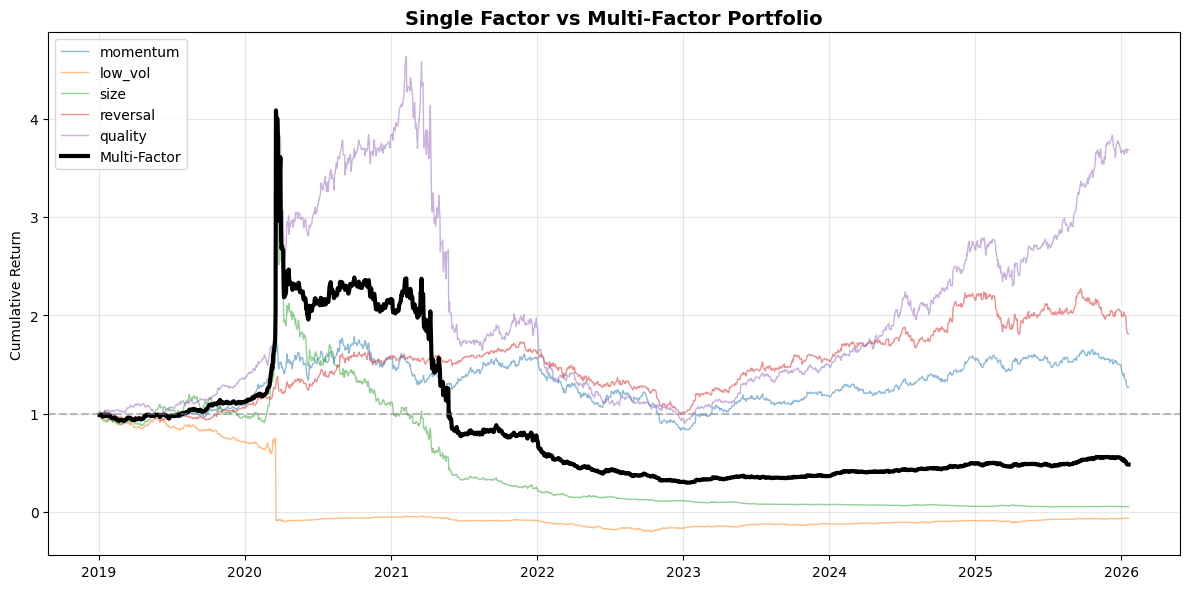

In [8]:
# Compare single-factor vs multi-factor
fig, ax = plt.subplots(figsize=(12, 6))

# Plot all single factors
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    ax.plot(cum_ret, label=factor, alpha=0.5, linewidth=1)

# Plot multi-factor
cum_mf = (1 + mf_returns).cumprod()
ax.plot(cum_mf, label='Multi-Factor', color='black', linewidth=3)

ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Single Factor vs Multi-Factor Portfolio', fontweight='bold', fontsize=14)
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Factor Neutralization

In [9]:
# Market-neutral portfolio construction
def build_market_neutral_portfolio(scores, returns, market_returns, target_beta=0):
    """Build a market-neutral portfolio."""
    # Get base long-short portfolio
    port_ret, longs, shorts = build_long_short_portfolio(scores, returns)
    
    # Calculate portfolio beta
    cov = np.cov(port_ret.dropna(), market_returns.loc[port_ret.dropna().index])[0, 1]
    var_mkt = market_returns.loc[port_ret.dropna().index].var()
    beta = cov / var_mkt
    
    # Hedge with market
    hedge_ratio = beta - target_beta
    hedged_returns = port_ret - hedge_ratio * market_returns.loc[port_ret.index]
    
    return hedged_returns, beta, hedge_ratio

market_proxy = returns['SPY']

print("\n" + "="*60)
print("MARKET-NEUTRAL FACTOR PORTFOLIOS")
print("="*60)
print(f"{'Factor':<15} {'Original β':<12} {'Hedge Ratio':<12} {'Hedged Sharpe':<12}")
print("-"*55)

neutral_portfolios = {}
for factor in factor_scores_z.columns:
    hedged_ret, orig_beta, hedge = build_market_neutral_portfolio(
        factor_scores_z[factor], returns, market_proxy
    )
    neutral_portfolios[factor] = hedged_ret
    
    hedged_sharpe = (hedged_ret.mean() * TRADING_DAYS) / (hedged_ret.std() * np.sqrt(TRADING_DAYS))
    print(f"{factor:<15} {orig_beta:<12.3f} {hedge:<12.3f} {hedged_sharpe:<12.3f}")


MARKET-NEUTRAL FACTOR PORTFOLIOS
Factor          Original β   Hedge Ratio  Hedged Sharpe
-------------------------------------------------------
momentum        -0.049       -0.049       0.306       
low_vol         -1.013       -1.013       -0.013      
size            -0.909       -0.909       -0.288      
reversal        0.241        0.241        0.333       
quality         0.674        0.674        0.326       


## 5. Factor Portfolio Optimization

In [10]:
# Optimize factor weights to maximize Sharpe
factor_returns_df = pd.DataFrame(factor_portfolios)

def portfolio_performance(weights, returns_df):
    """Calculate portfolio Sharpe ratio."""
    port_ret = (returns_df * weights).sum(axis=1)
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    return ann_ret, ann_vol, ann_ret/ann_vol if ann_vol > 0 else 0

def neg_sharpe(weights, returns_df):
    """Negative Sharpe for minimization."""
    _, _, sharpe = portfolio_performance(weights, returns_df)
    return -sharpe

# Optimize
n_factors = len(factor_returns_df.columns)
init_weights = np.ones(n_factors) / n_factors

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((-1, 1) for _ in range(n_factors))  # Allow short

result = minimize(neg_sharpe, init_weights, args=(factor_returns_df,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

print("\n" + "="*60)
print("OPTIMAL FACTOR WEIGHTS")
print("="*60)
for factor, weight in zip(factor_returns_df.columns, optimal_weights):
    print(f"{factor}: {weight:.3f}")

# Compare performance
eq_ret, eq_vol, eq_sharpe = portfolio_performance(init_weights, factor_returns_df)
opt_ret, opt_vol, opt_sharpe = portfolio_performance(optimal_weights, factor_returns_df)

print(f"\n{'Metric':<15} {'Equal Weight':<15} {'Optimized':<15}")
print("-"*45)
print(f"{'Return':<15} {eq_ret:<15.2%} {opt_ret:<15.2%}")
print(f"{'Volatility':<15} {eq_vol:<15.2%} {opt_vol:<15.2%}")
print(f"{'Sharpe':<15} {eq_sharpe:<15.3f} {opt_sharpe:<15.3f}")


OPTIMAL FACTOR WEIGHTS
momentum: -0.112
low_vol: 0.574
size: -0.421
reversal: -0.040
quality: 1.000

Metric          Equal Weight    Optimized      
---------------------------------------------
Return          -1.07%          28.57%         
Volatility      14.03%          18.69%         
Sharpe          -0.077          1.528          


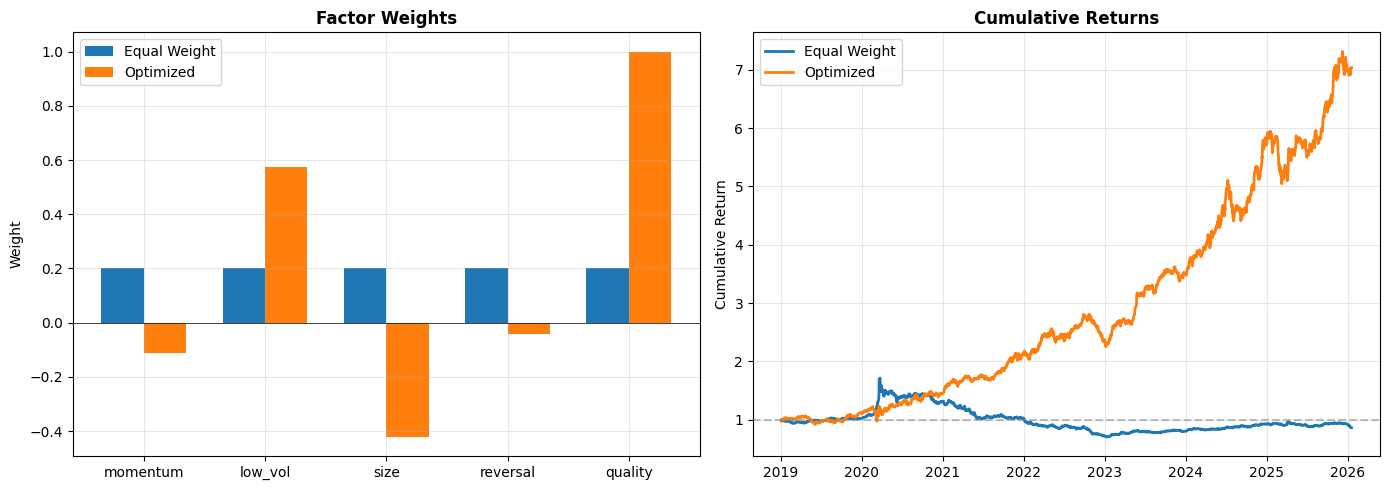

In [11]:
# Visualize optimized vs equal-weight
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weights comparison
ax1 = axes[0]
x = np.arange(n_factors)
width = 0.35
ax1.bar(x - width/2, init_weights, width, label='Equal Weight')
ax1.bar(x + width/2, optimal_weights, width, label='Optimized')
ax1.set_xticks(x)
ax1.set_xticklabels(factor_returns_df.columns)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_ylabel('Weight')
ax1.set_title('Factor Weights', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative returns
ax2 = axes[1]
eq_port = (factor_returns_df * init_weights).sum(axis=1)
opt_port = (factor_returns_df * optimal_weights).sum(axis=1)

ax2.plot((1 + eq_port).cumprod(), label='Equal Weight', linewidth=2)
ax2.plot((1 + opt_port).cumprod(), label='Optimized', linewidth=2)
ax2.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Cumulative Returns', fontweight='bold')
ax2.set_ylabel('Cumulative Return')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Long-short portfolios** isolate factor exposure and can be market-neutral
2. **Factor scores** ranked by z-score determine long/short positions
3. **Multi-factor** combines multiple signals for diversification
4. **Market neutralization** hedges out systematic risk
5. **Weight optimization** can improve risk-adjusted returns

### Portfolio Construction Framework
1. Calculate factor scores
2. Standardize scores (z-score)
3. Rank and select long/short positions
4. Apply neutralization if desired
5. Optimize factor weights

---
*Next: Day 7 - Interview Questions & Review*